In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Fri Jan 26 17:07:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize300/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

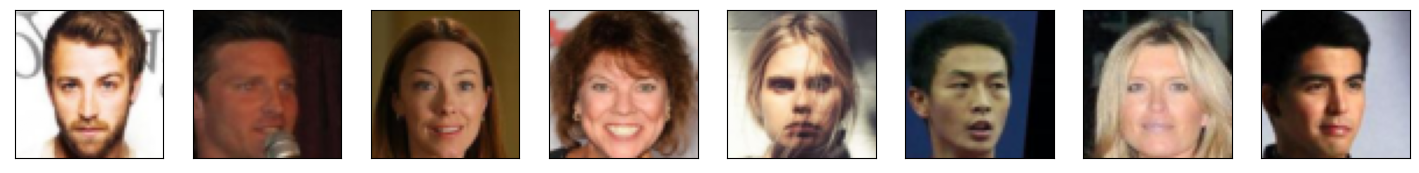

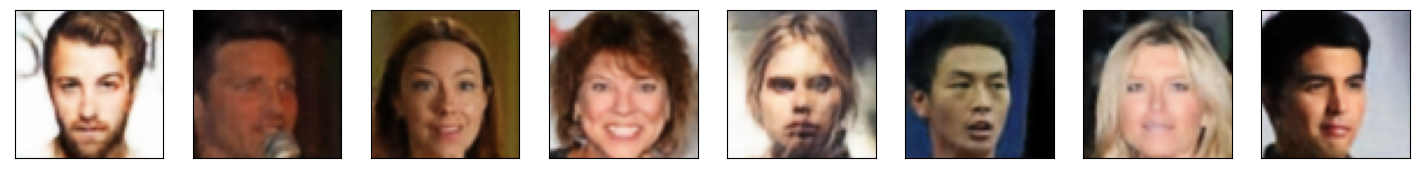

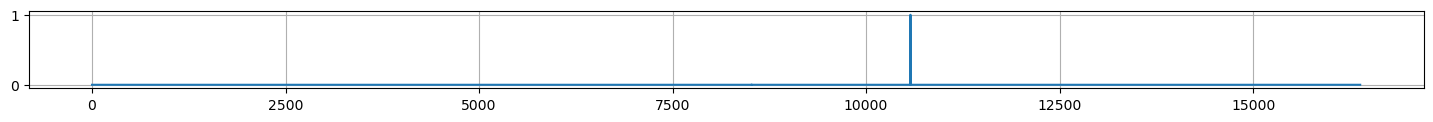

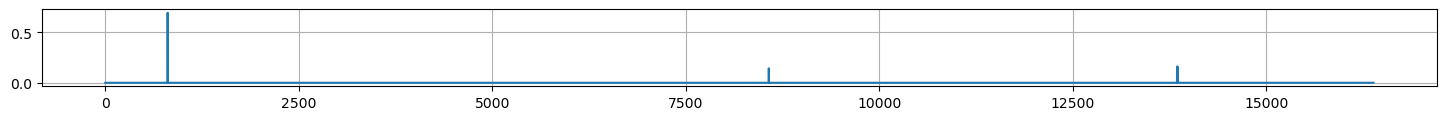

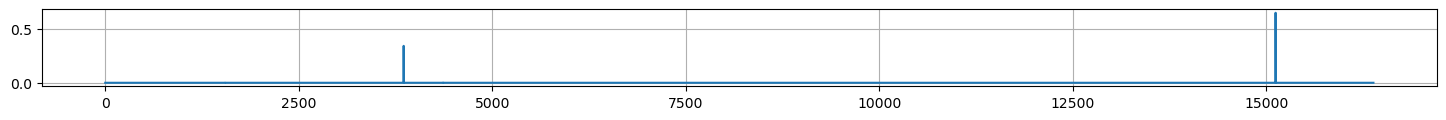

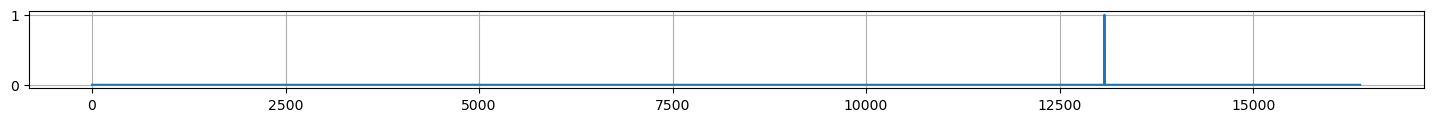

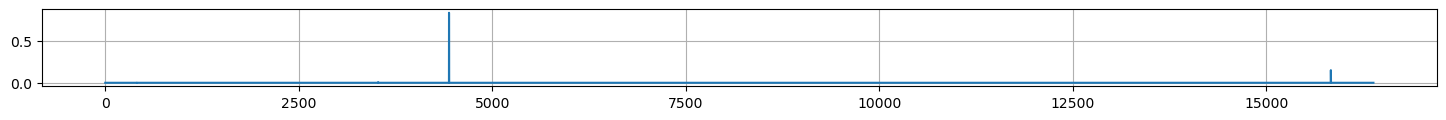

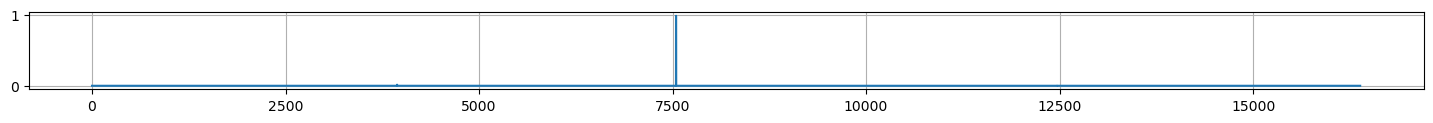

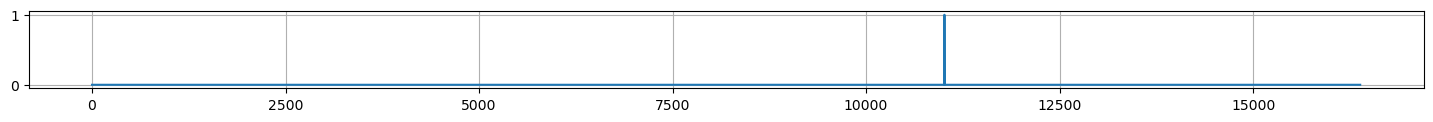

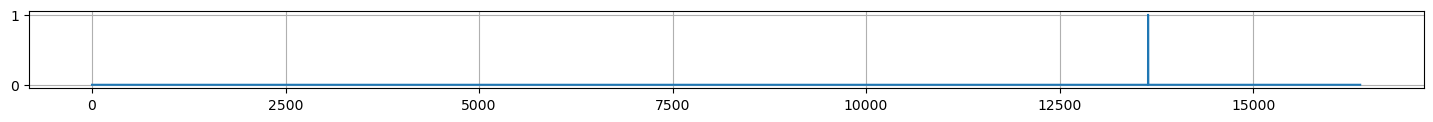

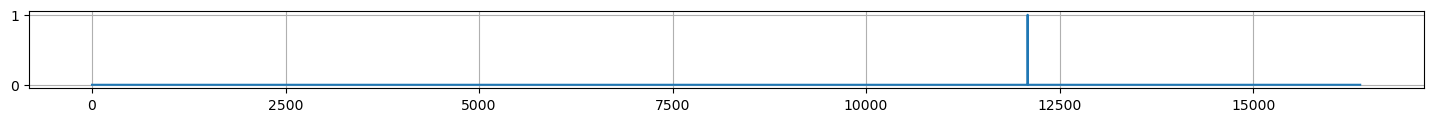

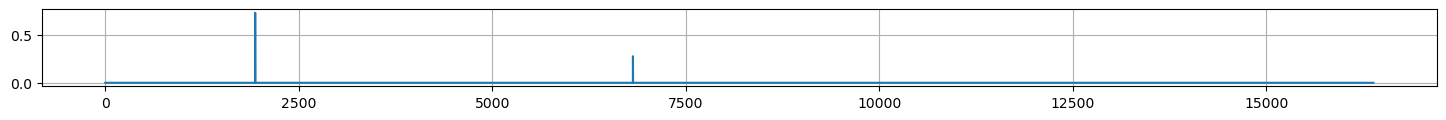

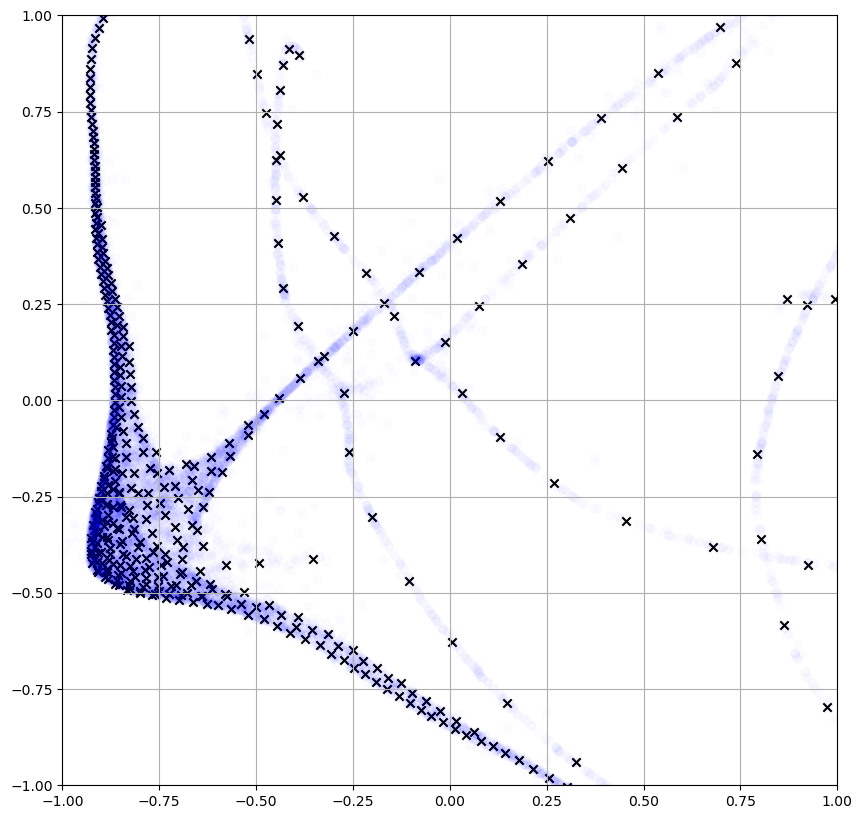

2001
lse_loss -403.5216064453125
commit_loss 7.30418469174765e-05
recon_loss 0.000766187789849937
2002
lse_loss -410.04364013671875
commit_loss 7.098031346686184e-05
recon_loss 0.0008264401694759727
2003
lse_loss -410.37939453125
commit_loss 7.226638990687206e-05
recon_loss 0.0006940425373613834
2004
lse_loss -412.3872985839844
commit_loss 7.192466000560671e-05
recon_loss 0.0007879248587414622
2005
lse_loss -405.2198181152344
commit_loss 7.413037383230403e-05
recon_loss 0.000749354949221015
2006
lse_loss -407.36517333984375
commit_loss 7.338819705182686e-05
recon_loss 0.0007696202956140041
2007
lse_loss -410.87091064453125
commit_loss 7.325794285861775e-05
recon_loss 0.0007322306628338993
2008
lse_loss -405.52325439453125
commit_loss 7.137859938666224e-05
recon_loss 0.0008595196413807571
2009
lse_loss -396.9807434082031
commit_loss 6.979225145187229e-05
recon_loss 0.0007416931330226362
2010
lse_loss -405.73199462890625
commit_loss 7.087393896654248e-05
recon_loss 0.0007908676634542644


2085
lse_loss -410.2613830566406
commit_loss 7.635427755303681e-05
recon_loss 0.0007375515997409821
2086
lse_loss -414.43853759765625
commit_loss 7.158453809097409e-05
recon_loss 0.0007171436445787549
2087
lse_loss -405.87774658203125
commit_loss 7.835549331502989e-05
recon_loss 0.0007567930733785033
2088
lse_loss -410.5435791015625
commit_loss 7.288382767001167e-05
recon_loss 0.0007383279735222459
2089
lse_loss -410.5707702636719
commit_loss 7.116475171642378e-05
recon_loss 0.0009105349308811128
2090
lse_loss -412.8798522949219
commit_loss 7.349826046265662e-05
recon_loss 0.0009924272308126092
2091
lse_loss -406.8532409667969
commit_loss 7.581218233099207e-05
recon_loss 0.000720015843398869
2092
lse_loss -410.46099853515625
commit_loss 7.614069909323007e-05
recon_loss 0.0008315418381243944
2093
lse_loss -412.95159912109375
commit_loss 7.553613249910995e-05
recon_loss 0.0007211308693513274
2094
lse_loss -411.0268859863281
commit_loss 7.07833532942459e-05
recon_loss 0.000699399912264198

2169
lse_loss -406.9197692871094
commit_loss 7.598547381348908e-05
recon_loss 0.0007574569317512214
2170
lse_loss -414.1206970214844
commit_loss 6.831081554992124e-05
recon_loss 0.00065135199110955
2171
lse_loss -414.8853454589844
commit_loss 7.314061804208905e-05
recon_loss 0.0007184696150943637
2172
lse_loss -408.3795471191406
commit_loss 7.527692650910467e-05
recon_loss 0.0007788082002662122
2173
lse_loss -406.28997802734375
commit_loss 7.122765964595601e-05
recon_loss 0.0007685859454795718
2174
lse_loss -413.5198669433594
commit_loss 7.083648961270228e-05
recon_loss 0.0007221288979053497
2175
lse_loss -409.936279296875
commit_loss 7.035011367406696e-05
recon_loss 0.0007650167681276798
2176
lse_loss -415.0418395996094
commit_loss 7.087607809808105e-05
recon_loss 0.0007207449525594711
2177
lse_loss -408.8344421386719
commit_loss 7.258848927449435e-05
recon_loss 0.0006697836215607822
2178
lse_loss -416.50421142578125
commit_loss 7.44996577850543e-05
recon_loss 0.0006521535106003284
21

lse_loss -413.66192626953125
commit_loss 7.342496246565133e-05
recon_loss 0.000823256908915937
2254
lse_loss -408.41943359375
commit_loss 7.199315587058663e-05
recon_loss 0.0008914778009057045
2255
lse_loss -410.28350830078125
commit_loss 7.306402403628454e-05
recon_loss 0.0007334918482229114
2256
lse_loss -410.9601745605469
commit_loss 7.617945084348321e-05
recon_loss 0.0007703708251938224
2257
lse_loss -414.5789489746094
commit_loss 8.375691686524078e-05
recon_loss 0.0008725014049559832
2258
lse_loss -411.842041015625
commit_loss 7.904918311396614e-05
recon_loss 0.0007558823563158512
2259
lse_loss -414.9640808105469
commit_loss 7.953027670737356e-05
recon_loss 0.000844558235257864
2260
lse_loss -407.8636474609375
commit_loss 7.599339005537331e-05
recon_loss 0.0008745937957428396
2261
lse_loss -411.8448791503906
commit_loss 7.464761438313872e-05
recon_loss 0.0007722514565102756
2262
lse_loss -411.0937805175781
commit_loss 8.035977953113616e-05
recon_loss 0.0008390058646909893
2263
lse

2338
lse_loss -404.9294128417969
commit_loss 7.297488627955317e-05
recon_loss 0.000776295957621187
2339
lse_loss -402.5431213378906
commit_loss 7.249309419421479e-05
recon_loss 0.0007582752732560039
2340
lse_loss -368.2678527832031
commit_loss 7.23609555279836e-05
recon_loss 0.0007426317315548658
2341
lse_loss -405.0376892089844
commit_loss 7.13751360308379e-05
recon_loss 0.0008003432303667068
2342
lse_loss -401.7003173828125
commit_loss 7.448010728694499e-05
recon_loss 0.000726954429410398
2343
lse_loss -396.6564025878906
commit_loss 7.434916915372014e-05
recon_loss 0.0007359354640357196
2344
lse_loss -402.5035095214844
commit_loss 7.014966104179621e-05
recon_loss 0.0007468961994163692
2345
lse_loss -401.67218017578125
commit_loss 7.474137237295508e-05
recon_loss 0.0008954135118983686
2346
lse_loss -402.0080261230469
commit_loss 7.93378203525208e-05
recon_loss 0.0007873218855820596
2347
lse_loss -403.56512451171875
commit_loss 7.492541772080585e-05
recon_loss 0.0007445345399901271
234

2423
lse_loss -408.4237365722656
commit_loss 7.44279968785122e-05
recon_loss 0.0008439585799351335
2424
lse_loss -405.6368713378906
commit_loss 7.040111813694239e-05
recon_loss 0.0007481559878215194
2425
lse_loss -405.9265441894531
commit_loss 7.6318669016473e-05
recon_loss 0.0008806057157926261
2426
lse_loss -410.09521484375
commit_loss 7.263521547429264e-05
recon_loss 0.0008111220668070018
2427
lse_loss -411.0425109863281
commit_loss 6.956071592867374e-05
recon_loss 0.0007544807158410549
2428
lse_loss -411.85382080078125
commit_loss 7.483010267606005e-05
recon_loss 0.0007321324083022773
2429
lse_loss -410.1831970214844
commit_loss 7.006148371146992e-05
recon_loss 0.0008125471649691463
2430
lse_loss -410.9502868652344
commit_loss 7.128845754778013e-05
recon_loss 0.0006787569145672023
2431
lse_loss -407.78363037109375
commit_loss 7.082332012942061e-05
recon_loss 0.0007012236746959388
2432
lse_loss -410.6122741699219
commit_loss 7.114282925613225e-05
recon_loss 0.0006934931734576821
243

2506
lse_loss -394.5378112792969
commit_loss 7.410041871480644e-05
recon_loss 0.0007999631343409419
2507
lse_loss -401.55987548828125
commit_loss 6.97929717716761e-05
recon_loss 0.0007077929913066328
2508
lse_loss -409.405029296875
commit_loss 7.425293733831495e-05
recon_loss 0.0007511690491810441
2509
lse_loss -406.1750183105469
commit_loss 7.11608154233545e-05
recon_loss 0.0007129068835638463
2510
lse_loss -408.23687744140625
commit_loss 7.099096546880901e-05
recon_loss 0.000732847023755312
2511
lse_loss -409.42169189453125
commit_loss 7.338079740293324e-05
recon_loss 0.0008373537566512823
2512
lse_loss -396.1351623535156
commit_loss 7.500288484152406e-05
recon_loss 0.0008871213067322969
2513
lse_loss -402.23272705078125
commit_loss 7.000977348070592e-05
recon_loss 0.0007493961602449417
2514
lse_loss -409.15350341796875
commit_loss 7.114378968253732e-05
recon_loss 0.0007482790388166904
2515
lse_loss -403.28839111328125
commit_loss 7.297636329894885e-05
recon_loss 0.000849012751132249

lse_loss -406.0078125
commit_loss 6.782454147469252e-05
recon_loss 0.0007766631315462291
2589
lse_loss -407.3955993652344
commit_loss 7.184331479948014e-05
recon_loss 0.0008704299107193947
2590
lse_loss -411.45587158203125
commit_loss 7.28489612811245e-05
recon_loss 0.0007217027014121413
2591
lse_loss -409.8056640625
commit_loss 7.69312318880111e-05
recon_loss 0.0008149665081873536
2592
lse_loss -411.7166442871094
commit_loss 7.249314512591809e-05
recon_loss 0.00077414809493348
2593
lse_loss -413.4518737792969
commit_loss 7.011897105257958e-05
recon_loss 0.0007675706292502582
2594
lse_loss -404.5453186035156
commit_loss 7.260566053446382e-05
recon_loss 0.0007928413688205183
2595
lse_loss -410.7056884765625
commit_loss 7.033786823740229e-05
recon_loss 0.0008071562624536455
2596
lse_loss -409.8014221191406
commit_loss 7.388450467260554e-05
recon_loss 0.000848520896397531
2597
lse_loss -411.8453369140625
commit_loss 7.409795944113284e-05
recon_loss 0.0008141015423461795
2598
lse_loss -408

2673
lse_loss -408.14190673828125
commit_loss 7.156949868658558e-05
recon_loss 0.0007765334448777139
2674
lse_loss -410.4577331542969
commit_loss 7.080118666635826e-05
recon_loss 0.0006919484585523605
2675
lse_loss -411.57568359375
commit_loss 6.912524258950725e-05
recon_loss 0.0007417664746753871
2676
lse_loss -410.6840515136719
commit_loss 7.073624146869406e-05
recon_loss 0.0007346696220338345
2677
lse_loss -414.6053161621094
commit_loss 6.736975046806037e-05
recon_loss 0.0007444905932061374
2678
lse_loss -408.6774597167969
commit_loss 7.021991041256115e-05
recon_loss 0.0007543551619164646
2679
lse_loss -411.0068359375
commit_loss 6.778868555556983e-05
recon_loss 0.0007140882080420852
2680
lse_loss -409.95672607421875
commit_loss 7.337265560636297e-05
recon_loss 0.0007389473612420261
2681
lse_loss -408.4137268066406
commit_loss 7.087901758495718e-05
recon_loss 0.0006463740719482303
2682
lse_loss -413.31829833984375
commit_loss 6.622378714382648e-05
recon_loss 0.0006792640197090805
26

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 300*1000)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 